# cNVAE Workflow: Training and Visualization

This notebook provides a complete workflow for:
1. **Environment Setup**: Initialize virtual environment and install dependencies
2. **Model Initialization**: Configure and create the cNVAE model
3. **Training**: Train the model from scratch or resume from checkpoint
4. **Loading**: Load pre-trained models
5. **Evaluation**: Run various tests and visualizations
6. **Analysis**: Generate plots, compute metrics, and analyze results

In [1]:
# 1. Install dependencies (run once)
import sys
import subprocess

def install_requirements():
    """Install required packages from requirements.txt"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
        print("✓ Dependencies installed successfully!")
    except Exception as e:
        print(f"✗ Error installing dependencies: {e}")

# Uncomment to install
# install_requirements()

In [9]:
# 2. Import libraries and setup paths
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import collections
import gc

# Clear memory
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Import cNVAE modules
from vae.vae2d import VAE
from vae.config_vae import ConfigVAE, ConfigTrainVAE
from vae.train_vae import TrainerVAE
from base.dataset import ROFLDS
from figures.fighelper import show_opticflow, show_opticflow_full, plot_heatmap, plot_bar

# Set random seeds for reproducibility
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

print("Checking available devices...")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Use MPS if available, otherwise CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"✓ Using MPS device")
else:
    device = torch.device('cpu')
    print(f"Using CPU device")
print(f"Device: {device}")

# Set paths
BASE_DIR = Path('/Users/mike/berkeley/rctn/ROFL-cNVAE')
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'

print(f"\nBase directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")

Checking available devices...
MPS available: True
CUDA available: False
✓ Using MPS device
Device: mps

Base directory: /Users/mike/berkeley/rctn/ROFL-cNVAE
Data directory: /Users/mike/berkeley/rctn/ROFL-cNVAE/data
Models directory: /Users/mike/berkeley/rctn/ROFL-cNVAE/models


In [3]:
# 2a. Verify or generate ROFL dataset (skip if exists)
from base.dataset import generate_simulation, save_simulation

dataset_path = DATA_DIR / 'fixate1_dim-17_n-750k'

if dataset_path.exists():
    print(f"✓ Dataset found at {dataset_path}")
    # Verify files exist
    required_files = ['attrs.npy', 'trn/x.npy', 'vld/x.npy', 'tst/x.npy']
    all_exist = all((dataset_path / f).exists() for f in required_files)
    if all_exist:
        print("✓ All required files present")
        # Count samples
        trn_size = np.load(dataset_path / 'trn' / 'x.npy', mmap_mode='r').shape[0]
        vld_size = np.load(dataset_path / 'vld' / 'x.npy', mmap_mode='r').shape[0]
        tst_size = np.load(dataset_path / 'tst' / 'x.npy', mmap_mode='r').shape[0]
        print(f"  Training samples: {trn_size:,}")
        print(f"  Validation samples: {vld_size:,}")
        print(f"  Test samples: {tst_size:,}")
        print(f"  Total: {trn_size + vld_size + tst_size:,}")
    else:
        print("✗ Some files missing - regenerating dataset")
        np.random.seed(SEED)
        kwargs = {
            'dim': 17, 'fov': 15.0, 'res': 1.0, 'z_bg': 100.0,
            'obj_r': 5.0, 'obj_bound': 5.0, 'obj_zlim': [20.0, 80.0],
            'vlim_slf': [2.0, 10.0], 'vlim_obj': [2.0, 10.0],
            'residual': False,
        }
        x, g, g_aux, attrs = generate_simulation(
            category='fixate', n_obj=1, total=750000,
            kwargs=kwargs, accept_n={0: 1, 1: 1}, min_obj_size=2,
        )
        x_max = np.percentile(np.abs(x), 98)
        x = np.clip(x, -x_max, x_max) / (x_max + 1e-6)
        save_simulation(save_dir=str(DATA_DIR), x=x, g=g, g_aux=g_aux, attrs=attrs)
        print(f"✓ Dataset regenerated")
else:
    print(f"Dataset not found at {dataset_path}")
    print("Generating dataset (this may take 5-10 minutes)...\n")
    np.random.seed(SEED)
    kwargs = {
        'dim': 17, 'fov': 15.0, 'res': 1.0, 'z_bg': 100.0,
        'obj_r': 5.0, 'obj_bound': 5.0, 'obj_zlim': [20.0, 80.0],
        'vlim_slf': [2.0, 10.0], 'vlim_obj': [2.0, 10.0],
        'residual': False,
    }
    x, g, g_aux, attrs = generate_simulation(
        category='fixate', n_obj=1, total=750000,
        kwargs=kwargs, accept_n={0: 1, 1: 1}, min_obj_size=2,
    )
    x_max = np.percentile(np.abs(x), 98)
    x = np.clip(x, -x_max, x_max) / (x_max + 1e-6)
    save_simulation(save_dir=str(DATA_DIR), x=x, g=g, g_aux=g_aux, attrs=attrs)
    print(f"✓ Dataset created at {DATA_DIR}")

✓ Dataset found at /Users/mike/berkeley/rctn/ROFL-cNVAE/data/fixate1_dim-17_n-750k
✓ All required files present
  Training samples: 600,000
  Validation samples: 75,000
  Test samples: 75,000
  Total: 750,000


In [4]:
# 3. Configure model architecture (ULTRA-COMPACT FOR MPS)
model_config = {
    'sim': 'fixate1',           # Simulation category: 'fixate', 'transl', or 'obj'
    'n_ch': 8,                  # Number of base channels (reduced from 16)
    'input_sz': 17,             # Input dimension (17x17)
    'ker_sz': 2,                # Kernel size
    'res_eps': 0.1,             # Residual epsilon
    
    # Encoder architecture (minimal)
    'n_enc_cells': 1,           # Number of encoder cells per group
    'n_enc_nodes': 1,           # Number of nodes per encoder cell (reduced from 2)
    
    # Decoder architecture (minimal)
    'n_dec_cells': 1,           # Number of decoder cells per group
    'n_dec_nodes': 1,           # Number of nodes per decoder cell
    
    # Pre/post processing (minimal)
    'n_pre_cells': 1,           # Preprocessing cells (reduced from 2)
    'n_pre_blocks': 1,          # Preprocessing blocks
    'n_post_cells': 1,          # Postprocessing cells (reduced from 2)
    'n_post_blocks': 1,         # Postprocessing blocks
    
    # Latent space configuration (highly reduced)
    'n_latent_scales': 3,       # Number of hierarchical scales
    'n_latent_per_group': 4,    # Latents per group (reduced from 8)
    'n_groups_per_scale': 5,    # Groups per scale (reduced from 10)
    
    # Additional settings
    'activation_fn': 'swish',
    'balanced_recon': True,
    'residual_kl': True,
    'ada_groups': True,         # Adaptive groups
    'compress': True,           # Compress latent space
    'use_se': False,            # Disable Squeeze-and-Excitation to save params
    'use_bn': False,            # Batch normalization
    'weight_norm': False,       # Weight normalization
    'spectral_norm': 0,         # Spectral normalization (0=off)
    'full': False,              # Don't load dataset info
    'save': False,              # Don't save config
    'base_dir': str(BASE_DIR),  # Set correct base directory
    'seed': SEED,
}

print("Model Configuration (ULTRA-COMPACT):")
for key, val in model_config.items():
    print(f"  {key}: {val}")


Model Configuration (ULTRA-COMPACT):
  sim: fixate1
  n_ch: 8
  input_sz: 17
  ker_sz: 2
  res_eps: 0.1
  n_enc_cells: 1
  n_enc_nodes: 1
  n_dec_cells: 1
  n_dec_nodes: 1
  n_pre_cells: 1
  n_pre_blocks: 1
  n_post_cells: 1
  n_post_blocks: 1
  n_latent_scales: 3
  n_latent_per_group: 4
  n_groups_per_scale: 5
  activation_fn: swish
  balanced_recon: True
  residual_kl: True
  ada_groups: True
  compress: True
  use_se: False
  use_bn: False
  weight_norm: False
  spectral_norm: 0
  full: False
  save: False
  base_dir: /Users/mike/berkeley/rctn/ROFL-cNVAE
  seed: 0


In [4]:
# 4. Configure training hyperparameters
train_config = {
    'lr': 0.002,                # Learning rate
    'epochs': 160,              # Number of training epochs
    'batch_size': 64,           # Batch size (ultra-compact model, small batch)
    'warm_restart': 0,          # Warm restart cycles
    'warmup_portion': 0.0125,   # Warmup portion
    'optimizer': 'adamax_fast', # Optimizer choice
    'scheduler_type': 'cosine', # LR scheduler
    'ema_rate': 0.999,          # EMA decay rate
    'grad_clip': 250,           # Gradient clipping
    'use_amp': False,           # Automatic mixed precision
    
    # KL divergence settings
    'kl_beta': 1.0,             # KL coefficient
    'kl_beta_min': 1e-4,        # Minimum KL coefficient
    'kl_balancer': 'equal',     # KL balancer type
    'kl_anneal_cycles': 0,      # Annealing cycles (0=linear)
    'kl_anneal_portion': 0.5,   # Portion for annealing
    'kl_const_portion': 0.01,   # Constant portion
    
    # Regularization
    'lambda_anneal': True,      # Anneal regularization
    'lambda_norm': 1e-3,        # Weight regularization strength
    'lambda_init': 1e-7,        # Initial regularization
    'spectral_reg': False,      # Spectral regularization
    
    # Logging and checkpointing
    'chkpt_freq': 10,           # Checkpoint frequency (epochs)
    'eval_freq': 2,             # Evaluation frequency (epochs)
    'log_freq': 10,             # Logging frequency (iterations)
}

print("Training Configuration:")
for key, val in train_config.items():
    print(f"  {key}: {val}")


Training Configuration:
  lr: 0.002
  epochs: 160
  batch_size: 64
  warm_restart: 0
  warmup_portion: 0.0125
  optimizer: adamax_fast
  scheduler_type: cosine
  ema_rate: 0.999
  grad_clip: 250
  use_amp: False
  kl_beta: 1.0
  kl_beta_min: 0.0001
  kl_balancer: equal
  kl_anneal_cycles: 0
  kl_anneal_portion: 0.5
  kl_const_portion: 0.01
  lambda_anneal: True
  lambda_norm: 0.001
  lambda_init: 1e-07
  spectral_reg: False
  chkpt_freq: 10
  eval_freq: 2
  log_freq: 10


In [6]:
# 5. Initialize model
# Force reload of modules to get latest changes
import importlib
import sys

# Remove cached modules to clear old configurations
for mod in list(sys.modules.keys()):
    if 'base' in mod or 'vae' in mod or 'analysis' in mod:
        del sys.modules[mod]

# Reimport with fresh modules
from vae.vae2d import VAE
from vae.config_vae import ConfigVAE, ConfigTrainVAE

# Create model configuration object
cfg_vae = ConfigVAE(**model_config)

# Initialize the VAE model
vae_model = VAE(cfg_vae)

# Move model to device
vae_model = vae_model.to(device)

# Print model summary
print(f"\nModel: {cfg_vae.name()}")
print(f"Total parameters: {sum(p.numel() for p in vae_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")
print(f"Total latent dimensions: {vae_model.total_latents()}")

# Display architecture details
enc_ftrs, dec_ftrs = vae_model.ftr_sizes()
print(f"\nEncoder features per scale: {enc_ftrs}")
print(f"Decoder features per scale: {dec_ftrs}")
print(f"Number of convolutional layers: {len(vae_model.all_conv_layers)}")



Model: fixate1_z-4x[2,2,5]_k-8_d-17_enc(1x1)-dec(1x1)-pre(1x1)-post(1x1)
Total parameters: 361,658
Trainable parameters: 361,658
Total latent dimensions: 36

Encoder features per scale: {8: 96, 4: 96, 2: 192}
Decoder features per scale: {2: 64, 4: 96, 8: 96}
Number of convolutional layers: 66


In [5]:
# 6. Create training configuration and setup data loaders
cfg_train = ConfigTrainVAE(**train_config)

print(f"Trainer configuration: {cfg_train.name()}")
print(f"Training parameters:")
print(f"  Learning rate: {cfg_train.lr}")
print(f"  Epochs: {cfg_train.epochs}")
print(f"  Batch size: {cfg_train.batch_size}")
print(f"  KL beta: {cfg_train.kl_beta}\n")

# Manually setup data loaders without using TrainerVAE (avoids PyTorch compatibility issues)
from torch.utils.data import DataLoader

try:
    # Load datasets
    ds_trn = ROFLDS(str(dataset_path), 'trn', device=None)
    ds_vld = ROFLDS(str(dataset_path), 'vld', device=None)
    ds_tst = ROFLDS(str(dataset_path), 'tst', device=None)
    
    # Create dataloaders
    dl_trn = DataLoader(ds_trn, batch_size=cfg_train.batch_size, shuffle=True, drop_last=True, num_workers=0)
    dl_vld = DataLoader(ds_vld, batch_size=cfg_train.batch_size, shuffle=False, drop_last=False, num_workers=0)
    dl_tst = DataLoader(ds_tst, batch_size=cfg_train.batch_size, shuffle=False, drop_last=False, num_workers=0)
    
    print(f"✓ Data loaders created:")
    print(f"  Training batches: {len(dl_trn)}")
    print(f"  Validation batches: {len(dl_vld)}")
    print(f"  Test batches: {len(dl_tst)}")
    
except Exception as e:
    print(f"✗ Error creating data loaders: {e}")
    dl_trn = dl_vld = dl_tst = None


Trainer configuration: ep160-b64-lr(0.002)_beta(1:0x0.5)_lamb(0.001)_gr(250)
Training parameters:
  Learning rate: 0.002
  Epochs: 160
  Batch size: 64
  KL beta: 1.0

✓ Data loaders created:
  Training batches: 9375
  Validation batches: 1172
  Test batches: 1172


In [8]:
# 6a. Train the model with MPS GPU and comprehensive logging
from tqdm import tqdm
import time

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Device: {device}")
print(f"Model: {cfg_vae.name()}")
print(f"Parameters: {sum(p.numel() for p in vae_model.parameters()):,}")
print(f"Latent dims: {vae_model.total_latents()}")
print(f"Learning rate: {cfg_train.lr}")
print(f"Batch size: {cfg_train.batch_size}")
print(f"Gradient clipping: {cfg_train.grad_clip}")
print(f"KL beta: {cfg_train.kl_beta}")
print(f"Weight regularization: {cfg_train.lambda_norm}")
print("=" * 70)

# Setup training
vae_model.train()
vae_model = vae_model.to(device)

# Manual optimizer state (Adam algorithm)
adam_state = {}
for param in vae_model.parameters():
    adam_state[param] = {
        'step': 0,
        'm': torch.zeros_like(param.data),  # First moment
        'v': torch.zeros_like(param.data),  # Second moment
    }

# Hyperparameters
lr = cfg_train.lr
beta1, beta2 = 0.9, 0.999
eps = 1e-8

def manual_adam_step():
    """Manual Adam optimizer step"""
    for param in vae_model.parameters():
        if param.grad is None:
            continue
        
        state = adam_state[param]
        grad = param.grad.data
        
        # Update step
        state['step'] += 1
        
        # Update biased first moment estimate
        state['m'].mul_(beta1).add_(grad, alpha=1 - beta1)
        
        # Update biased second raw moment estimate
        state['v'].mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        
        # Compute bias-corrected first moment estimate
        m_hat = state['m'] / (1 - beta1 ** state['step'])
        
        # Compute bias-corrected second raw moment estimate
        v_hat = state['v'] / (1 - beta2 ** state['step'])
        
        # Update parameters
        param.data.add_(m_hat / (v_hat.sqrt() + eps), alpha=-lr)

# Training parameters
n_epochs = 5  # Reduce for demo; set to 160 for full training
save_dir = MODELS_DIR / cfg_vae.name()
save_dir.mkdir(parents=True, exist_ok=True)

print(f"\nStarting training for {n_epochs} epochs...")
print(f"Model will be saved to: {save_dir}\n")

train_losses = []
val_losses = []
best_val_loss = float('inf')

# Detailed logging
epoch_times = []
batch_times = []

for epoch in range(n_epochs):
    epoch_start = time.time()
    
    # Training phase
    vae_model.train()
    epoch_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0
    
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch+1}/{n_epochs}")
    print(f"{'='*70}")
    
    pbar = tqdm(dl_trn, desc=f"Training", leave=True)
    for batch_idx, (x, norm) in enumerate(pbar):
        batch_start = time.time()
        
        x = x.to(device)
        norm = norm.to(device)
        
        # Zero gradients manually
        for param in vae_model.parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        # Forward pass
        y, latents, q_all, p_all = vae_model(x)
        
        # Compute reconstruction loss
        epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
        
        # Compute KL divergence loss
        kl_all, kl_diag = vae_model.loss_kl(q_all, p_all)
        kl_loss = torch.stack(kl_all).sum(dim=0)  # Sum over latent groups
        
        # Total loss (ELBO = reconstruction + KL)
        loss = torch.mean(epe + cfg_train.kl_beta * kl_loss)
        
        # Add weight regularization if applicable
        loss_w = vae_model.loss_weight()
        if loss_w is not None:
            loss += cfg_train.lambda_norm * loss_w
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        grad_norm = torch.nn.utils.clip_grad_norm_(vae_model.parameters(), cfg_train.grad_clip)
        
        # Manual optimizer step
        manual_adam_step()
        
        # Track losses
        epoch_loss += loss.item()
        epoch_recon_loss += torch.mean(epe).item()
        epoch_kl_loss += torch.mean(kl_loss).item()
        
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        # Update progress bar with detailed info
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'recon': f'{torch.mean(epe).item():.4f}',
            'kl': f'{torch.mean(kl_loss).item():.4f}',
            'grad': f'{grad_norm.item():.2f}',
            'time': f'{batch_time:.3f}s'
        })
        
        # Debug logging every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"\n  Batch {batch_idx+1}/{len(dl_trn)}:")
            print(f"    Total loss: {loss.item():.4f}")
            print(f"    Recon loss: {torch.mean(epe).item():.4f}")
            print(f"    KL loss: {torch.mean(kl_loss).item():.4f}")
            print(f"    Grad norm: {grad_norm.item():.2f}")
            print(f"    Batch time: {batch_time:.3f}s")
            if loss_w is not None:
                print(f"    Weight reg: {loss_w.item():.6f}")
    
    train_loss = epoch_loss / len(dl_trn)
    train_recon = epoch_recon_loss / len(dl_trn)
    train_kl = epoch_kl_loss / len(dl_trn)
    train_losses.append(train_loss)
    
    print(f"\n  Training Summary:")
    print(f"    Avg total loss: {train_loss:.4f}")
    print(f"    Avg recon loss: {train_recon:.4f}")
    print(f"    Avg KL loss: {train_kl:.4f}")
    
    # Validation phase
    print(f"\n  Running validation...")
    vae_model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kl_loss = 0
    
    with torch.no_grad():
        for x, norm in tqdm(dl_vld, desc="Validation", leave=False):
            x = x.to(device)
            norm = norm.to(device)
            
            # Forward pass
            y, latents, q_all, p_all = vae_model(x)
            
            # Compute losses
            epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
            kl_all, kl_diag = vae_model.loss_kl(q_all, p_all)
            kl_loss = torch.stack(kl_all).sum(dim=0)
            loss = torch.mean(epe + cfg_train.kl_beta * kl_loss)
            
            val_loss += loss.item()
            val_recon_loss += torch.mean(epe).item()
            val_kl_loss += torch.mean(kl_loss).item()
    
    val_loss = val_loss / len(dl_vld)
    val_recon = val_recon_loss / len(dl_vld)
    val_kl = val_kl_loss / len(dl_vld)
    val_losses.append(val_loss)
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    
    print(f"\n  Validation Summary:")
    print(f"    Avg total loss: {val_loss:.4f}")
    print(f"    Avg recon loss: {val_recon:.4f}")
    print(f"    Avg KL loss: {val_kl:.4f}")
    
    print(f"\n  Epoch {epoch+1} completed in {epoch_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Save best checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': vae_model.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_recon': train_recon,
            'train_kl': train_kl,
            'val_recon': val_recon,
            'val_kl': val_kl,
        }
        torch.save(checkpoint, save_dir / 'checkpoint_best.pt')
        print(f"  ✓ Best model saved (val_loss: {val_loss:.4f})")

print(f"\n{'='*70}")
print("TRAINING COMPLETE")
print(f"{'='*70}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Total training time: {sum(epoch_times):.2f}s")
print(f"Avg time per epoch: {np.mean(epoch_times):.2f}s")
print(f"Avg time per batch: {np.mean(batch_times):.4f}s")
print(f"Checkpoints saved to: {save_dir}")
print(f"{'='*70}")


TRAINING CONFIGURATION
Device: mps
Model: fixate1_z-4x[2,2,5]_k-8_d-17_enc(1x1)-dec(1x1)-pre(1x1)-post(1x1)
Parameters: 361,658
Latent dims: 36
Learning rate: 0.002
Batch size: 64
Gradient clipping: 250
KL beta: 1.0
Weight regularization: 0.001

Starting training for 5 epochs...
Model will be saved to: /Users/mike/berkeley/rctn/ROFL-cNVAE/models/fixate1_z-4x[2,2,5]_k-8_d-17_enc(1x1)-dec(1x1)-pre(1x1)-post(1x1)


EPOCH 1/5


Training:   0%|          | 0/9375 [00:00<?, ?it/s]/Users/mike/berkeley/rctn/ROFL-cNVAE/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/Users/mike/berkeley/rctn/ROFL-cNVAE/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want t


  Batch 100/9375:
    Total loss: 35.8177
    Recon loss: 35.7979
    KL loss: 0.0198
    Grad norm: 169.29
    Batch time: 0.808s
    Weight reg: 0.000760


Training:   2%|▏         | 200/9375 [03:19<2:08:24,  1.19it/s, loss=34.5636, recon=34.5553, kl=0.0084, grad=67.28, time=0.811s] 


  Batch 200/9375:
    Total loss: 34.5636
    Recon loss: 34.5553
    KL loss: 0.0084
    Grad norm: 67.28
    Batch time: 0.811s
    Weight reg: 0.001188


Training:   3%|▎         | 300/9375 [04:56<2:11:55,  1.15it/s, loss=34.0884, recon=34.0824, kl=0.0059, grad=9.73, time=0.805s]  


  Batch 300/9375:
    Total loss: 34.0884
    Recon loss: 34.0824
    KL loss: 0.0059
    Grad norm: 9.73
    Batch time: 0.805s
    Weight reg: 0.001591


Training:   4%|▍         | 400/9375 [06:42<2:35:01,  1.04s/it, loss=26.3270, recon=26.3233, kl=0.0037, grad=158.59, time=0.995s]


  Batch 400/9375:
    Total loss: 26.3270
    Recon loss: 26.3233
    KL loss: 0.0037
    Grad norm: 158.59
    Batch time: 0.995s
    Weight reg: 0.001955


Training:   5%|▌         | 500/9375 [08:28<3:05:27,  1.25s/it, loss=29.6315, recon=29.6274, kl=0.0041, grad=145.50, time=1.253s]


  Batch 500/9375:
    Total loss: 29.6315
    Recon loss: 29.6274
    KL loss: 0.0041
    Grad norm: 145.50
    Batch time: 1.253s
    Weight reg: 0.002300


Training:   6%|▋         | 600/9375 [10:33<3:07:38,  1.28s/it, loss=40.8238, recon=40.8188, kl=0.0050, grad=46.33, time=1.246s] 


  Batch 600/9375:
    Total loss: 40.8238
    Recon loss: 40.8188
    KL loss: 0.0050
    Grad norm: 46.33
    Batch time: 1.246s
    Weight reg: 0.002614


Training:   7%|▋         | 700/9375 [12:48<3:23:37,  1.41s/it, loss=28.9161, recon=28.9134, kl=0.0027, grad=64.62, time=1.530s] 


  Batch 700/9375:
    Total loss: 28.9161
    Recon loss: 28.9134
    KL loss: 0.0027
    Grad norm: 64.62
    Batch time: 1.530s
    Weight reg: 0.002956


Training:   9%|▊         | 800/9375 [15:31<4:12:23,  1.77s/it, loss=33.0690, recon=33.0672, kl=0.0019, grad=22.28, time=1.508s] 


  Batch 800/9375:
    Total loss: 33.0690
    Recon loss: 33.0672
    KL loss: 0.0019
    Grad norm: 22.28
    Batch time: 1.508s
    Weight reg: 0.003235


Training:   9%|▉         | 852/9375 [16:54<2:49:09,  1.19s/it, loss=37.3778, recon=37.3755, kl=0.0023, grad=126.75, time=1.314s]



KeyboardInterrupt: 

Sample optical flow data:
  Shape: (16, 2, 17, 17)
  Min: -1.0000, Max: 1.0000
  Mean: 0.0276, Std: 0.2511

  Individual sample statistics:
    Sample 1: vx_mean=-0.2383, vy_mean=-0.0952, mag_max=1.0840
    Sample 2: vx_mean=0.0717, vy_mean=0.0616, mag_max=0.3720
    Sample 3: vx_mean=-0.0377, vy_mean=0.0171, mag_max=0.5323
    Sample 4: vx_mean=0.1993, vy_mean=0.4773, mag_max=1.2466



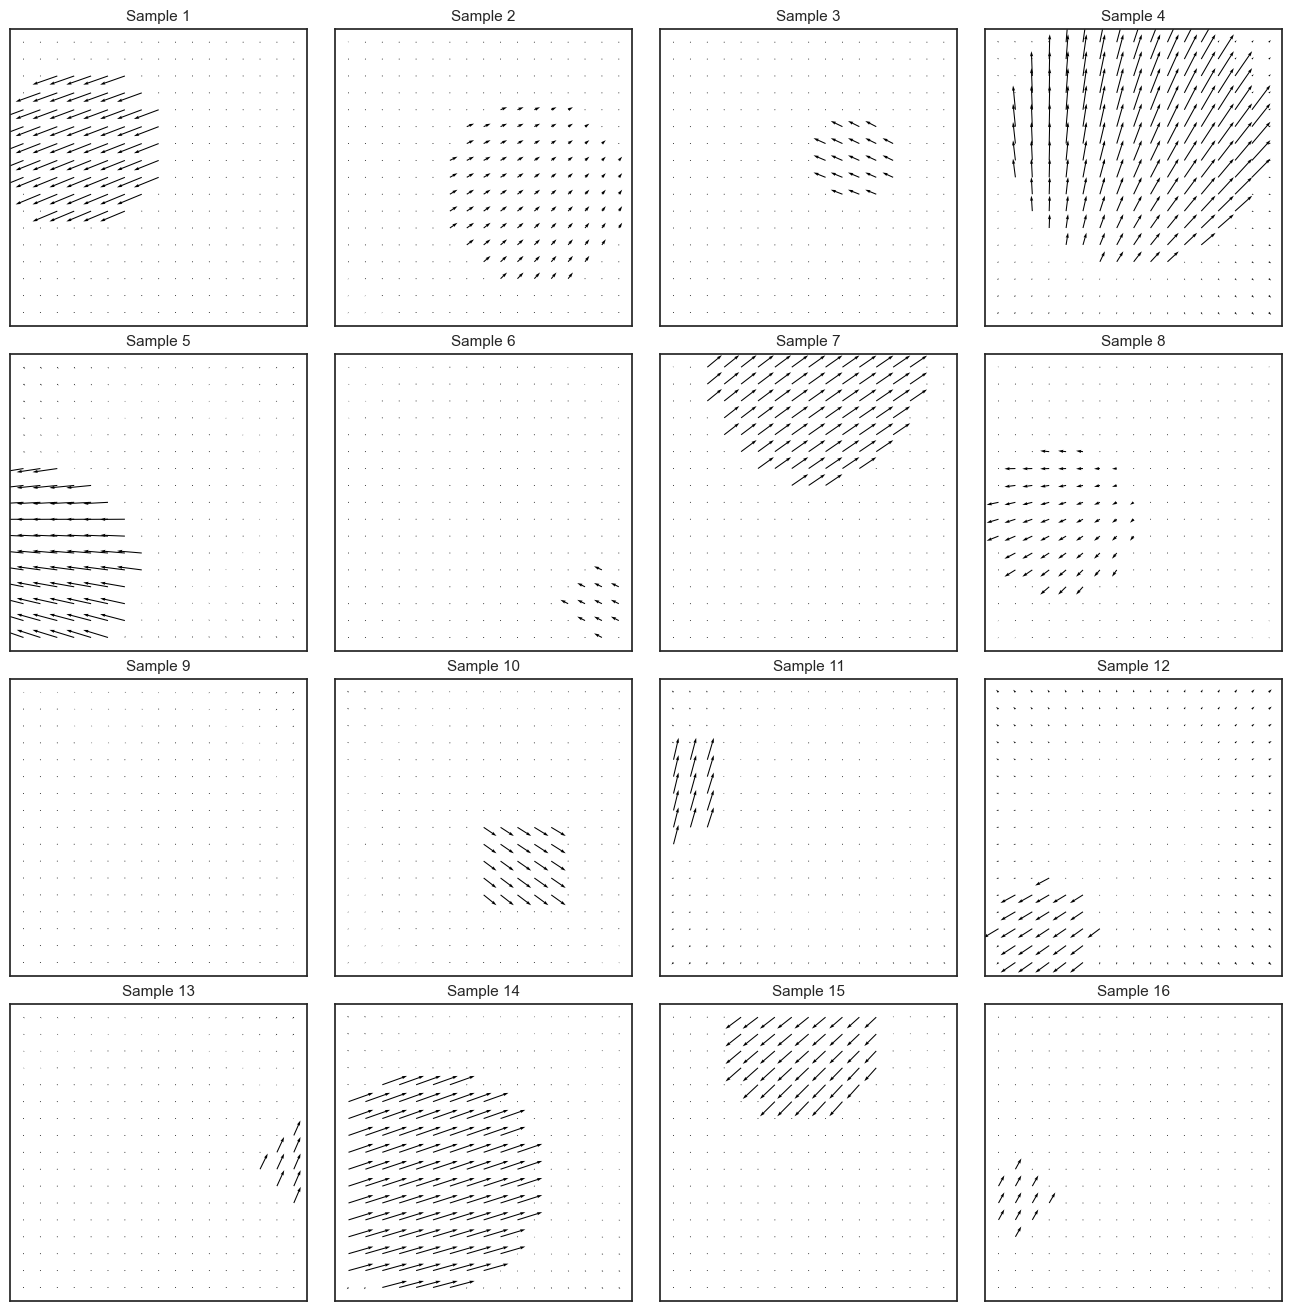

✓ Arrow plot visualization complete! Each arrow shows the optical flow direction and magnitude at each spatial location (17×17 grid).


<Figure size 500x320 with 0 Axes>

In [7]:
# 6b. Visualize sample optical flow data with arrow plots
# Select random indices from training set
np.random.seed(SEED)
sample_indices = np.random.choice(len(ds_trn), size=16, replace=False)

# Load sample optical flows
samples = []
for idx in sample_indices:
    x, norm = ds_trn[idx]
    samples.append(x)

samples = np.array(samples)  # Shape: (16, 2, 17, 17)

print(f"Sample optical flow data:")
print(f"  Shape: {samples.shape}")
print(f"  Min: {samples.min():.4f}, Max: {samples.max():.4f}")
print(f"  Mean: {samples.mean():.4f}, Std: {samples.std():.4f}")
print(f"\n  Individual sample statistics:")

# Show stats for each sample
for i in range(min(4, len(samples))):
    mag = np.sqrt(samples[i, 0]**2 + samples[i, 1]**2)
    print(f"    Sample {i+1}: vx_mean={samples[i,0].mean():.4f}, vy_mean={samples[i,1].mean():.4f}, mag_max={mag.max():.4f}")

print()

# Visualize with arrow plots (4x4 grid)
fig, axes = show_opticflow(
    samples,
    num=4,
    titles=[f"Sample {i+1}" for i in range(16)],
    no_ticks=True,
    display=True,
    figsize=(13, 13),
    scale=12,  # Arrow scale factor
)

fig.suptitle('Random Samples from Training Dataset (Optical Flow)', fontsize=16, y=0.995, fontweight='bold')
plt.tight_layout()

print("✓ Arrow plot visualization complete! Each arrow shows the optical flow direction and magnitude at each spatial location (17×17 grid).")

Displaying detailed breakdown of Sample 4 (highest mean magnitude: 0.5757)

Optical flow components:
  vx (horizontal): min=-0.0973, max=0.7484
  vy (vertical):   min=-0.0955, max=1.0000



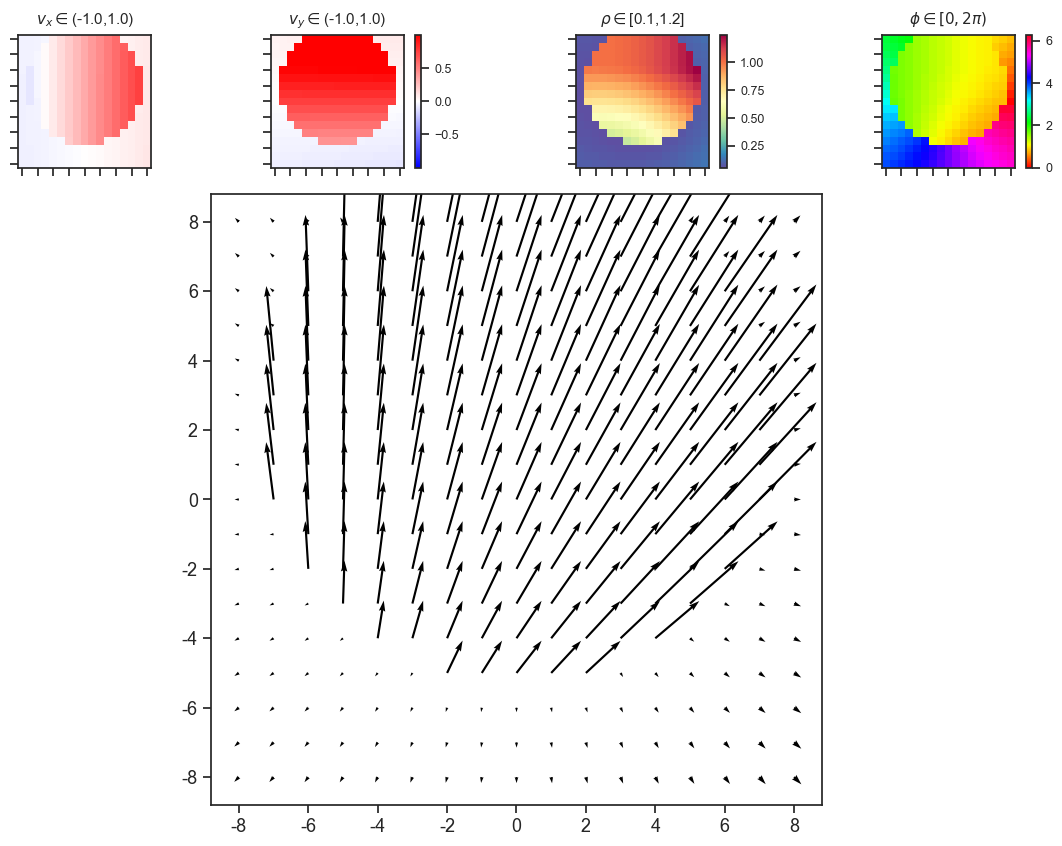

✓ Detailed visualization complete!

Interpretation:
  - vx: Horizontal velocity component (blue=leftward, red=rightward)
  - vy: Vertical velocity component (blue=upward, red=downward)
  - ρ (rho): Magnitude of flow (speed)
  - φ (phi): Direction of flow in polar coordinates
  - Bottom: Quiver plot showing 2D flow vectors at each location


<Figure size 500x320 with 0 Axes>

In [10]:
# 6c. Show detailed view of a single optical flow sample with component breakdown
# Select one interesting sample (with highest magnitude)
magnitudes = []
for i, sample in enumerate(samples):
    mag = np.sqrt(sample[0]**2 + sample[1]**2)
    magnitudes.append(mag.mean())

best_idx = np.argmax(magnitudes)
selected_sample = samples[best_idx:best_idx+1]

print(f"Displaying detailed breakdown of Sample {best_idx + 1} (highest mean magnitude: {magnitudes[best_idx]:.4f})")
print(f"\nOptical flow components:")
print(f"  vx (horizontal): min={selected_sample[0,0].min():.4f}, max={selected_sample[0,0].max():.4f}")
print(f"  vy (vertical):   min={selected_sample[0,1].min():.4f}, max={selected_sample[0,1].max():.4f}\n")

# Show detailed visualization with component breakdown
fig, axes = show_opticflow_full(
    selected_sample[0],
    cbar=True,
    display=True,
    figsize=(14, 10),
    title_fontsize=11,
    tick_spacing=2,
    scale=8,
)

fig.suptitle('Detailed Optical Flow Breakdown (vx, vy, magnitude, phase)', fontsize=14, y=0.995, fontweight='bold')
plt.tight_layout()

print("✓ Detailed visualization complete!")
print("\nInterpretation:")
print("  - vx: Horizontal velocity component (blue=leftward, red=rightward)")
print("  - vy: Vertical velocity component (blue=upward, red=downward)")
print("  - ρ (rho): Magnitude of flow (speed)")
print("  - φ (phi): Direction of flow in polar coordinates")
print("  - Bottom: Quiver plot showing 2D flow vectors at each location")

In [9]:
# 6b. Evaluate on test set
import time

print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

vae_model.eval()
test_loss = 0
test_recon_loss = 0
test_kl_loss = 0
all_z = []
all_x = []
all_y = []

eval_start = time.time()

print("Evaluating on test set...")
with torch.no_grad():
    for batch_idx, (x, norm) in enumerate(tqdm(dl_tst, desc="Test evaluation")):
        x = x.to(device)
        norm = norm.to(device)
        
        # Forward pass
        y, latents, q_all, p_all = vae_model(x)
        
        # Compute losses
        epe = vae_model.loss_recon(x=x, y=y, w=1/norm)
        kl_all, kl_diag = vae_model.loss_kl(q_all, p_all)
        kl_loss = torch.stack(kl_all).sum(dim=0)
        loss = torch.mean(epe + cfg_train.kl_beta * kl_loss)
        
        test_loss += loss.item()
        test_recon_loss += torch.mean(epe).item()
        test_kl_loss += torch.mean(kl_loss).item()
        
        # Collect latents - concatenate all latent groups
        z_batch = torch.cat([z.reshape(z.size(0), -1) for z in latents], dim=1)
        all_z.append(z_batch.cpu().numpy())
        all_x.append(x.cpu().numpy())
        all_y.append(y.cpu().numpy())
        
        # Debug logging every 25 batches
        if (batch_idx + 1) % 25 == 0:
            print(f"  Batch {batch_idx+1}/{len(dl_tst)}: loss={loss.item():.4f}")

eval_time = time.time() - eval_start

test_loss = test_loss / len(dl_tst)
test_recon = test_recon_loss / len(dl_tst)
test_kl = test_kl_loss / len(dl_tst)

z_all = np.concatenate(all_z, axis=0)
x_all = np.concatenate(all_x, axis=0)
y_all = np.concatenate(all_y, axis=0)

print(f"\n{'='*70}")
print("EVALUATION RESULTS")
print(f"{'='*70}")
print(f"Test Loss Breakdown:")
print(f"  Total loss: {test_loss:.4f}")
print(f"  Reconstruction loss: {test_recon:.4f}")
print(f"  KL divergence loss: {test_kl:.4f}")
print(f"\nData Shapes:")
print(f"  Latent codes: {z_all.shape}")
print(f"  Original flows: {x_all.shape}")
print(f"  Reconstructed flows: {y_all.shape}")
print(f"\nEvaluation time: {eval_time:.2f}s")
print(f"{'='*70}")


TEST SET EVALUATION
Evaluating on test set...


Test evaluation:   2%|▏         | 25/1172 [00:05<03:32,  5.39it/s]

  Batch 25/1172: loss=35.6020


Test evaluation:   4%|▍         | 51/1172 [00:10<03:26,  5.43it/s]

  Batch 50/1172: loss=43.1109


Test evaluation:   6%|▋         | 76/1172 [00:14<03:38,  5.02it/s]

  Batch 75/1172: loss=35.3557


Test evaluation:   9%|▊         | 101/1172 [00:19<03:09,  5.65it/s]

  Batch 100/1172: loss=30.3536


Test evaluation:  11%|█         | 126/1172 [00:23<03:01,  5.76it/s]

  Batch 125/1172: loss=30.9270


Test evaluation:  13%|█▎        | 151/1172 [00:28<02:46,  6.14it/s]

  Batch 150/1172: loss=39.6965


Test evaluation:  15%|█▍        | 175/1172 [00:33<03:28,  4.78it/s]

  Batch 175/1172: loss=40.1750


Test evaluation:  17%|█▋        | 201/1172 [00:38<02:55,  5.53it/s]

  Batch 200/1172: loss=35.4003


Test evaluation:  19%|█▉        | 226/1172 [00:44<03:01,  5.20it/s]

  Batch 225/1172: loss=34.3635


Test evaluation:  21%|██▏       | 251/1172 [00:49<03:01,  5.07it/s]

  Batch 250/1172: loss=37.0781


Test evaluation:  24%|██▎       | 276/1172 [00:54<02:24,  6.22it/s]

  Batch 275/1172: loss=36.6588


Test evaluation:  26%|██▌       | 301/1172 [00:58<02:23,  6.07it/s]

  Batch 300/1172: loss=40.3100


Test evaluation:  28%|██▊       | 326/1172 [01:02<02:20,  6.01it/s]

  Batch 325/1172: loss=31.5820


Test evaluation:  30%|██▉       | 351/1172 [01:07<02:16,  5.99it/s]

  Batch 350/1172: loss=28.0383


Test evaluation:  32%|███▏      | 376/1172 [01:10<01:59,  6.64it/s]

  Batch 375/1172: loss=30.2815


Test evaluation:  34%|███▍      | 400/1172 [01:14<02:26,  5.27it/s]

  Batch 400/1172: loss=38.6543


Test evaluation:  36%|███▋      | 426/1172 [01:20<02:24,  5.15it/s]

  Batch 425/1172: loss=37.6335


Test evaluation:  38%|███▊      | 451/1172 [01:26<02:04,  5.78it/s]

  Batch 450/1172: loss=40.6485


Test evaluation:  41%|████      | 475/1172 [01:31<02:29,  4.66it/s]

  Batch 475/1172: loss=38.4070


Test evaluation:  43%|████▎     | 501/1172 [01:35<01:46,  6.30it/s]

  Batch 500/1172: loss=34.9887


Test evaluation:  45%|████▍     | 526/1172 [01:39<01:43,  6.22it/s]

  Batch 525/1172: loss=36.0229


Test evaluation:  47%|████▋     | 551/1172 [01:43<01:26,  7.20it/s]

  Batch 550/1172: loss=33.8830


Test evaluation:  49%|████▉     | 576/1172 [01:46<01:27,  6.83it/s]

  Batch 575/1172: loss=29.4315


Test evaluation:  51%|█████▏    | 601/1172 [01:50<01:17,  7.40it/s]

  Batch 600/1172: loss=28.9456


Test evaluation:  53%|█████▎    | 626/1172 [01:53<01:11,  7.65it/s]

  Batch 625/1172: loss=30.0512


Test evaluation:  56%|█████▌    | 651/1172 [01:56<01:05,  7.93it/s]

  Batch 650/1172: loss=32.0684


Test evaluation:  58%|█████▊    | 676/1172 [02:00<01:02,  7.90it/s]

  Batch 675/1172: loss=29.9662


Test evaluation:  60%|█████▉    | 701/1172 [02:03<01:00,  7.75it/s]

  Batch 700/1172: loss=30.7206


Test evaluation:  62%|██████▏   | 726/1172 [02:06<00:56,  7.93it/s]

  Batch 725/1172: loss=38.1051


Test evaluation:  64%|██████▍   | 751/1172 [02:11<01:39,  4.21it/s]

  Batch 750/1172: loss=27.2424


Test evaluation:  66%|██████▌   | 776/1172 [02:15<01:13,  5.41it/s]

  Batch 775/1172: loss=43.3887


Test evaluation:  68%|██████▊   | 801/1172 [02:19<00:56,  6.62it/s]

  Batch 800/1172: loss=33.4355


Test evaluation:  70%|███████   | 826/1172 [02:23<00:53,  6.48it/s]

  Batch 825/1172: loss=31.2212


Test evaluation:  73%|███████▎  | 851/1172 [02:27<01:01,  5.21it/s]

  Batch 850/1172: loss=33.8362


Test evaluation:  75%|███████▍  | 876/1172 [02:31<00:41,  7.13it/s]

  Batch 875/1172: loss=30.0444


Test evaluation:  77%|███████▋  | 901/1172 [02:34<00:34,  7.85it/s]

  Batch 900/1172: loss=38.1197


Test evaluation:  79%|███████▉  | 926/1172 [02:38<00:32,  7.68it/s]

  Batch 925/1172: loss=40.9101


Test evaluation:  81%|████████  | 951/1172 [02:41<00:28,  7.87it/s]

  Batch 950/1172: loss=39.9219


Test evaluation:  83%|████████▎ | 976/1172 [02:44<00:25,  7.67it/s]

  Batch 975/1172: loss=37.6253


Test evaluation:  85%|████████▌ | 1000/1172 [02:48<00:33,  5.08it/s]

  Batch 1000/1172: loss=37.6567


Test evaluation:  88%|████████▊ | 1026/1172 [02:52<00:18,  7.86it/s]

  Batch 1025/1172: loss=30.8546


Test evaluation:  90%|████████▉ | 1051/1172 [02:55<00:15,  7.93it/s]

  Batch 1050/1172: loss=34.6025


Test evaluation:  92%|█████████▏| 1076/1172 [02:59<00:19,  4.99it/s]

  Batch 1075/1172: loss=36.2981


Test evaluation:  94%|█████████▍| 1101/1172 [03:02<00:10,  7.00it/s]

  Batch 1100/1172: loss=30.5600


Test evaluation:  96%|█████████▌| 1126/1172 [03:06<00:05,  7.98it/s]

  Batch 1125/1172: loss=33.4767


Test evaluation:  98%|█████████▊| 1151/1172 [03:09<00:02,  7.91it/s]

  Batch 1150/1172: loss=37.6212


Test evaluation: 100%|██████████| 1172/1172 [03:14<00:00,  6.03it/s]




EVALUATION RESULTS
Test Loss Breakdown:
  Total loss: 34.5125
  Reconstruction loss: 34.5103
  KL divergence loss: 0.0022

Data Shapes:
  Latent codes: (75000, 36)
  Original flows: (75000, 2, 17, 17)
  Reconstructed flows: (75000, 2, 17, 17)

Evaluation time: 194.22s


Latent Space Analysis:
  Dimensionality: 36
  Number of samples: 75000

Latent Code Statistics:
  Mean: -0.0130
  Std: 0.9639
  Min: -4.8778
  Max: 4.7502


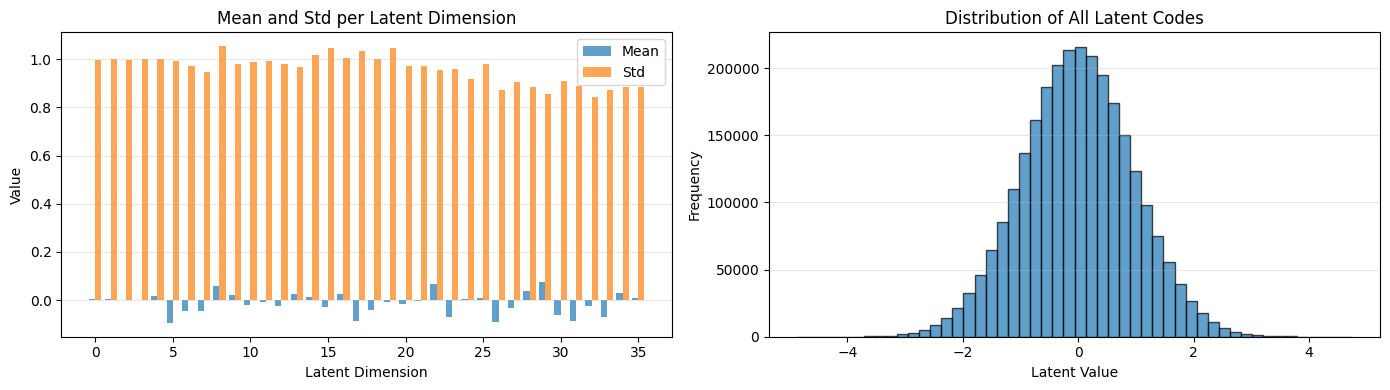


Latent Dimension Correlation:
  Max correlation: 0.0116
  Mean absolute correlation: 0.0029


In [10]:
# 7.3 Analyze latent space
print("Latent Space Analysis:")
print(f"  Dimensionality: {z_all.shape[1]}")
print(f"  Number of samples: {z_all.shape[0]}")

# Compute statistics
print(f"\nLatent Code Statistics:")
print(f"  Mean: {z_all.mean():.4f}")
print(f"  Std: {z_all.std():.4f}")
print(f"  Min: {z_all.min():.4f}")
print(f"  Max: {z_all.max():.4f}")

# Plot latent dimension statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Mean and std per dimension
ax = axes[0]
dim_means = z_all.mean(axis=0)
dim_stds = z_all.std(axis=0)
x_pos = np.arange(len(dim_means))
ax.bar(x_pos - 0.2, dim_means, 0.4, label='Mean', alpha=0.7)
ax.bar(x_pos + 0.2, dim_stds, 0.4, label='Std', alpha=0.7)
ax.set_xlabel('Latent Dimension')
ax.set_ylabel('Value')
ax.set_title('Mean and Std per Latent Dimension')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Distribution of all latent codes
ax = axes[1]
ax.hist(z_all.flatten(), bins=50, alpha=0.7, edgecolor='black')
ax.set_xlabel('Latent Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of All Latent Codes')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Compute correlation between dimensions
corr_matrix = np.corrcoef(z_all.T)
print(f"\nLatent Dimension Correlation:")
print(f"  Max correlation: {np.max(np.abs(corr_matrix - np.eye(corr_matrix.shape[0]))):.4f}")
print(f"  Mean absolute correlation: {np.mean(np.abs(corr_matrix - np.eye(corr_matrix.shape[0]))):.4f}")


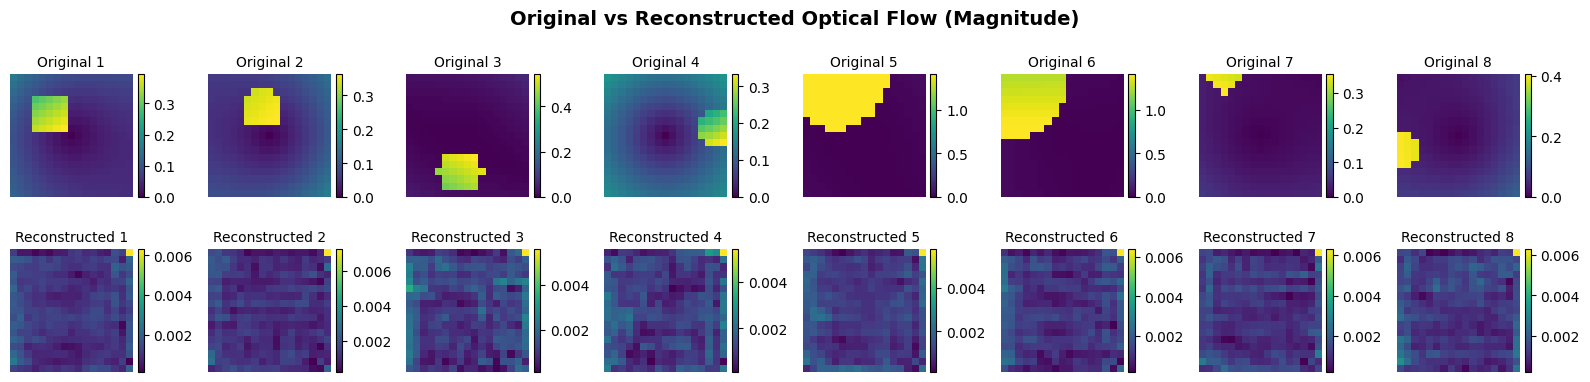


Reconstruction Error Statistics:
  Mean: 0.0426
  Std: 0.0711
  Min: 0.0000
  Max: 0.6134


In [16]:
# 7.2 Visualize original vs reconstructed optical flow
n_samples = 8
fig, axes = plt.subplots(2, n_samples, figsize=(16, 4))

for i in range(n_samples):
    # Original flow
    flow_orig = x_all[i]  # Shape: (2, 17, 17)
    magnitude_orig = np.sqrt(flow_orig[0]**2 + flow_orig[1]**2)
    
    ax = axes[0, i]
    im = ax.imshow(magnitude_orig, cmap='viridis')
    ax.set_title(f'Original {i+1}', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Reconstructed flow
    flow_recon = y_all[i]
    magnitude_recon = np.sqrt(flow_recon[0]**2 + flow_recon[1]**2)
    
    ax = axes[1, i]
    im = ax.imshow(magnitude_recon, cmap='viridis')
    ax.set_title(f'Reconstructed {i+1}', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Original vs Reconstructed Optical Flow (Magnitude)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate reconstruction error
recon_errors = np.mean((x_all - y_all)**2, axis=(1, 2, 3))
print(f"\nReconstruction Error Statistics:")
print(f"  Mean: {recon_errors.mean():.4f}")
print(f"  Std: {recon_errors.std():.4f}")
print(f"  Min: {recon_errors.min():.4f}")
print(f"  Max: {recon_errors.max():.4f}")


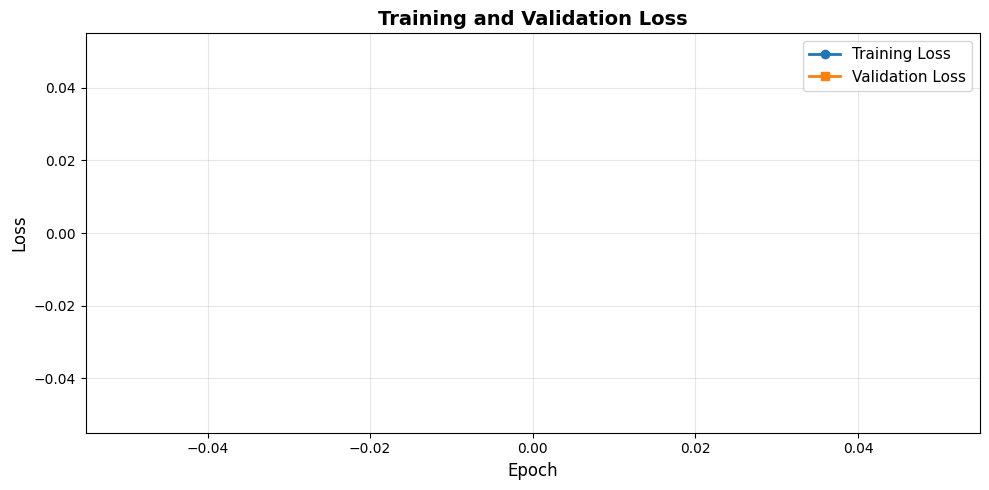

Training complete!


IndexError: list index out of range

In [15]:
# 7.1 Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Training Loss', marker='o', linewidth=2)
ax.plot(val_losses, label='Validation Loss', marker='s', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training complete!")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Final val loss: {val_losses[-1]:.4f}")
print(f"  Best val loss: {best_val_loss:.4f}")


## 7. Visualization

Visualize training curves, reconstructions, and latent space.


## 6b. Evaluate on Test Set

Evaluate the trained model on the test set.


## 6a. Training the Model

Train the cNVAE on the optical flow data.


## 6a. Train the Model

Train the cNVAE model on the generated dataset.


In [13]:
# 6b. Load existing model checkpoint (Option B)
def load_model_checkpoint(checkpoint_path, model, device='cpu'):
    """Load model from checkpoint"""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model.to(device)
    model.eval()
    
    # Print checkpoint info
    if 'epoch' in checkpoint:
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    if 'loss' in checkpoint:
        print(f"Checkpoint loss: {checkpoint['loss']:.4f}")
    
    return model

# Example: Load a checkpoint (uncomment to use)
# checkpoint_path = MODELS_DIR / cfg_vae.name() / "checkpoint_best.pt"
# vae_model = load_model_checkpoint(checkpoint_path, vae_model, device)
# print("✓ Model loaded successfully!")

print("Load function ready. See cell comments for usage.")

Load function ready. See cell comments for usage.


In [14]:
# 7. Forward pass and get reconstruction loss
# This requires the trainer to be initialized with data loaders

if 'trainer' in locals():
    print("Running forward pass on validation set...")
    
    # Get data and losses
    data_vld, loss_vld = trainer.forward('vld', use_ema=True)
    
    print(f"\nValidation Losses:")
    print(f"  Reconstruction (EPE): {loss_vld['epe'].mean():.4f}")
    print(f"  KL Divergence: {loss_vld['kl'].mean():.4f}")
    print(f"  Per-dim KL: {loss_vld['kl_diag'].mean():.4f}")
    
    # Extract latent representations
    z_vld = data_vld['z']
    print(f"\nLatent representation shape: {z_vld.shape}")
else:
    print("Trainer not initialized. Initialize trainer first to run evaluation.")

Trainer not initialized. Initialize trainer first to run evaluation.


In [ ]:
# 8. Generate samples from prior
if 'trainer' in locals():
    print("Generating samples from prior...")
    
    n_samples = 16  # Number of samples to generate
    temperature = 1.0  # Sampling temperature (0.0 = deterministic, 1.0 = full stochastic)
    
    x_sample, z_sample = trainer.sample(
        n_samples=n_samples,
        t=temperature,
        use_ema=True
    )
    
    print(f"Generated samples shape: {x_sample.shape}")
    print(f"Latent codes shape: {z_sample.shape}")
else:
    print("Trainer not initialized.")

Trainer not initialized.


In [ ]:
# 9. Visualize generated optic flow samples
if 'x_sample' in locals():
    print("Visualizing generated optic flow samples...")
    
    # Display generated samples
    fig, axes = show_opticflow(x_sample, n=6, display=True)
    plt.suptitle('Generated Optic Flow Samples', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No samples generated yet. Run the sampling cell first.")

No samples generated yet. Run the sampling cell first.


In [ ]:
# 10. Perform regression analysis on latent representations
if 'trainer' in locals():
    print("Running regression analysis...")
    
    regr_results = trainer.regress(n_fwd=0, use_ema=True)
    
    print(f"\nRegression Metrics:")
    print(f"  R (correlation): {np.diag(regr_results['regr/r']).mean():.4f}")
    print(f"  R² (variance explained): {np.nanmean(regr_results['regr/r2']) * 100:.2f}%")
    print(f"  Disentanglement: {regr_results['regr/d']:.4f}")
    print(f"  Completeness: {regr_results['regr/c']:.4f}")
    
    # Auxiliary factors
    print(f"\nAuxiliary Factors:")
    print(f"  R (correlation): {np.diag(regr_results['regr/aux/r']).mean():.4f}")
    print(f"  R² (variance explained): {np.nanmean(regr_results['regr/aux/r2']) * 100:.2f}%")
else:
    print("Trainer not initialized.")

Trainer not initialized.


In [ ]:
# 11. Plot correlation heatmap (regression results)
if 'regr_results' in locals() and 'trainer' in locals():
    print("Creating regression correlation heatmap...")
    
    # Get factor labels
    f = trainer.dl_tst.dataset.f
    _tx = [f"({i:02d})" for i in range(len(f))]
    _ty = [f"{e} ({i:02d})" for i, e in enumerate(f)]
    
    # Calculate statistics
    rd = np.diag(regr_results['regr/r'])
    title = f"all = {rd.mean():0.3f} ± {rd.std():0.3f} " + r'$(\ mu \pm \sigma)$' + '\n'
    
    # Group by factor name
    name_groups = collections.defaultdict(list)
    for i, lbl in enumerate(f):
        k = lbl.split('_')[0]
        name_groups[k].append(i)
    
    for i, (k, ids) in enumerate(name_groups.items()):
        title += f"{k}: {rd[ids].mean():0.2f}, "
        if (i + 1) % 3 == 0:
            title += '\n'
    
    # Plot heatmap
    fig, ax = plot_heatmap(
        r=regr_results['regr/r'],
        title=title,
        cmap='PiYG',
        xticklabels=_tx,
        yticklabels=_ty,
        annot_kws={'fontsize': 10},
        figsize=(0.6 * len(f), 0.5 * len(f)),
        display=True,
    )
    plt.tight_layout()
    plt.show()
else:
    print("No regression results available. Run regression analysis first.")

No regression results available. Run regression analysis first.


In [ ]:
# 12. Plot R² bar plots by factor
if 'regr_results' in locals() and 'trainer' in locals():
    print("Creating R² bar plots...")
    
    # Main factors
    df_main = pd.DataFrame({
        'x': trainer.dl_vld.dataset.f,
        'y': regr_results['regr/r2'],
    })
    
    fig, ax = plot_bar(df_main, tick_labelsize_x=9, display=True)
    plt.title('R² by Generative Factor', fontsize=12)
    plt.ylabel('R² Score (%)', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Auxiliary factors
    df_aux = pd.DataFrame({
        'x': trainer.dl_vld.dataset.f_aux,
        'y': regr_results['regr/aux/r2'],
    })
    
    fig, ax = plot_bar(df_aux, tick_labelsize_x=9, display=True)
    plt.title('R² by Auxiliary Factor', fontsize=12)
    plt.ylabel('R² Score (%)', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No regression results available.")

No regression results available.


In [ ]:
# 13. Plot mutual information heatmap (for compressed models)
if 'regr_results' in locals() and 'trainer' in locals() and vae_model.cfg.compress:
    if 'regr/mi' in regr_results:
        print("Creating mutual information heatmap...")
        
        f = trainer.dl_tst.dataset.f
        _ty = [f"{e} ({i:02d})" for i, e in enumerate(f)]
        
        title = '_'.join(vae_model.cfg.name().split('_')[:3])
        mi_max = np.round(np.max(regr_results['regr/mi'], axis=1), 2)
        mi_max_str = ', '.join([str(e) for e in mi_max])
        title = f"model = {title}; max MI (row) = {mi_max_str}"
        
        figsize = (0.08 * vae_model.total_latents(), 0.6 * len(f))
        
        fig, ax = plot_heatmap(
            r=regr_results['regr/mi'],
            yticklabels=_ty,
            title=title,
            tick_labelsize_x=8,
            tick_labelsize_y=7,
            title_fontsize=12,
            title_y=1.02,
            vmin=0,
            vmax=0.65,
            cmap='rocket',
            linecolor='dimgrey',
            figsize=figsize,
            cbar=True,
            annot=False,
            display=True,
        )
        plt.tight_layout()
        plt.show()
        
        print(f"\nMutual Information Statistics:")
        print(f"  Mean MI: {np.mean(regr_results['regr/mi']):.4f}")
        print(f"  Max MI per factor: {np.max(regr_results['regr/mi'], axis=1)}")
        print(f"  MIG (Mutual Information Gap): {regr_results['regr/mig'].mean():.4f}")
    else:
        print("Mutual information not computed. Run full validation with MI analysis.")
else:
    print("Mutual information only available for compressed models with full evaluation.")

Mutual information only available for compressed models with full evaluation.


In [ ]:
# 14. Analyze latent space structure and statistics
if 'regr_results' in locals():
    print("Latent Space Analysis:")
    
    z_vld = regr_results['z_vld']
    z_tst = regr_results['z_tst']
    
    print(f"\nValidation set:")
    print(f"  Shape: {z_vld.shape}")
    print(f"  Mean: {z_vld.mean():.4f}")
    print(f"  Std: {z_vld.std():.4f}")
    print(f"  Min: {z_vld.min():.4f}")
    print(f"  Max: {z_vld.max():.4f}")
    
    print(f"\nTest set:")
    print(f"  Shape: {z_tst.shape}")
    print(f"  Mean: {z_tst.mean():.4f}")
    print(f"  Std: {z_tst.std():.4f}")
    
    # Plot latent dimension statistics
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Mean and std per dimension
    ax = axes[0]
    ax.plot(z_vld.mean(axis=0), label='Mean', alpha=0.7)
    ax.plot(z_vld.std(axis=0), label='Std', alpha=0.7)
    ax.set_xlabel('Latent Dimension')
    ax.set_ylabel('Value')
    ax.set_title('Latent Statistics per Dimension')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Histogram of latent values
    ax = axes[1]
    ax.hist(z_vld.flatten(), bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Latent Value')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Latent Values')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No latent representations available.")

No latent representations available.


In [ ]:
# 15. Compare original vs reconstructed samples
if 'trainer' in locals():
    print("Evaluating reconstruction quality...")
    
    # Get a batch of validation data
    data_vld, loss_vld = trainer.forward('vld', use_ema=True)
    
    if data_vld['x'] is not None and data_vld['y'] is not None:
        x_orig = data_vld['x'][:8]  # First 8 samples
        x_recon = data_vld['y'][:8]
        
        # Plot original vs reconstructed
        fig, axes = plt.subplots(2, 4, figsize=(14, 7))
        
        for i in range(4):
            # Original
            ax = axes[0, i]
            flow = x_orig[i]
            if len(flow.shape) == 3:
                # Visualize flow magnitude
                magnitude = np.sqrt(flow[0]**2 + flow[1]**2)
                im = ax.imshow(magnitude, cmap='viridis')
                ax.set_title(f'Original {i+1}')
                ax.axis('off')
            
            # Reconstructed
            ax = axes[1, i]
            flow = x_recon[i]
            if len(flow.shape) == 3:
                magnitude = np.sqrt(flow[0]**2 + flow[1]**2)
                im = ax.imshow(magnitude, cmap='viridis')
                ax.set_title(f'Reconstructed {i+1}')
                ax.axis('off')
        
        plt.suptitle('Original vs Reconstructed Optic Flow', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Print reconstruction metrics
        print(f"\nReconstruction Metrics:")
        print(f"  Mean EPE: {loss_vld['epe'].mean():.4f}")
        print(f"  Std EPE: {loss_vld['epe'].std():.4f}")
    else:
        print("Reconstruction data not available in training mode.")
else:
    print("Trainer not initialized.")

Trainer not initialized.


In [ ]:
# 16. Utility functions for model management

def save_checkpoint(model, optimizer, epoch, loss, filepath):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'loss': loss,
    }
    torch.save(checkpoint, filepath)
    print(f"✓ Checkpoint saved: {filepath}")

def list_available_checkpoints(model_name, models_dir=MODELS_DIR):
    """List all available checkpoints for a model"""
    model_dir = models_dir / model_name
    if not model_dir.exists():
        print(f"No checkpoints found for model: {model_name}")
        return []
    
    checkpoints = list(model_dir.glob("*.pt"))
    if not checkpoints:
        print(f"No checkpoints found in: {model_dir}")
        return []
    
    print(f"Available checkpoints for {model_name}:")
    for i, ckpt in enumerate(checkpoints, 1):
        print(f"  {i}. {ckpt.name}")
    
    return checkpoints

def get_model_summary(model):
    """Print detailed model summary"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print("=" * 70)
    print("MODEL SUMMARY")
    print("=" * 70)
    print(f"Model Name: {model.cfg.name()}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {total_params - trainable_params:,}")
    print(f"Total Latents: {model.total_latents()}")
    print(f"Conv Layers: {len(model.all_conv_layers)}")
    print("=" * 70)
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'total_latents': model.total_latents(),
        'conv_layers': len(model.all_conv_layers)
    }

print("✓ Utility functions loaded")

✓ Utility functions loaded
